# **PlantCare - Leaf Disease Detection using Deep Learning**


In this notebook, we will utilize TensorFlow and pre-trained models to classify tomato leaf diseases using image datasets. We'll download the dataset, preprocess images, and train a convolutional neural network to achieve accurate classification.

## **Collecting Data**

### 1. Setting Up Kaggle API for Dataset Access

To access the dataset from Kaggle, we'll configure the environment by installing the kaggle library and authenticating using the Kaggle API key.

In [ ]:
pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/'kaggle.json'

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


### 2. Listing and Downloading Datasets from Kaggle

We'll list available datasets and download the one required for our project (tomatoleaf dataset).

In [ ]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
!kaggle datasets download -d 'kaustubhb999/tomatoleaf'

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
 99% 177M/179M [00:00<00:00, 179MB/s]
100% 179M/179M [00:00<00:00, 191MB/s]


### 3. Extracting the Downloaded Dataset

We'll extract the contents of the dataset zip file to access the training and validation images.

In [ ]:
import zipfile
import os
import shutil

In [ ]:
dataset_zip = zipfile.ZipFile('tomatoleaf.zip','r')
dataset_zip.extractall()
dataset_zip.close()

### 4. Importing Required Libraries

Importing essential Python libraries for deep learning, data preprocessing, and visualization.

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception, VGG16, VGG19

## **Cleaning and Formatting Data**

### 5. Loading and Preprocessing the Training Dataset

We will load the images from the training directory and apply image preprocessing techniques such as rescaling, random flipping, rotation, zooming, and contrast adjustment.

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/content/tomato/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

Found 10000 files belonging to 10 classes.


In [ ]:
from tensorflow.keras import layers

preprocessing_layers = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [ ]:
train_data = train_data.map(lambda x, y: (preprocessing_layers(x), y))

## **Dataset Preparation: Training, Validation, and Evaluation**

###  6. Loading and Preparing Validation Data

Similar to the training data, we load and preprocess the validation dataset.

In [ ]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/tomato/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

Found 1000 files belonging to 10 classes.


In [ ]:
val_data = val_data.map(lambda x, y: (preprocessing_layers(x), y))

### 7. Visualizing Sample Images from the Dataset

We will display some sample images from different disease categories to get an overview of the dataset.

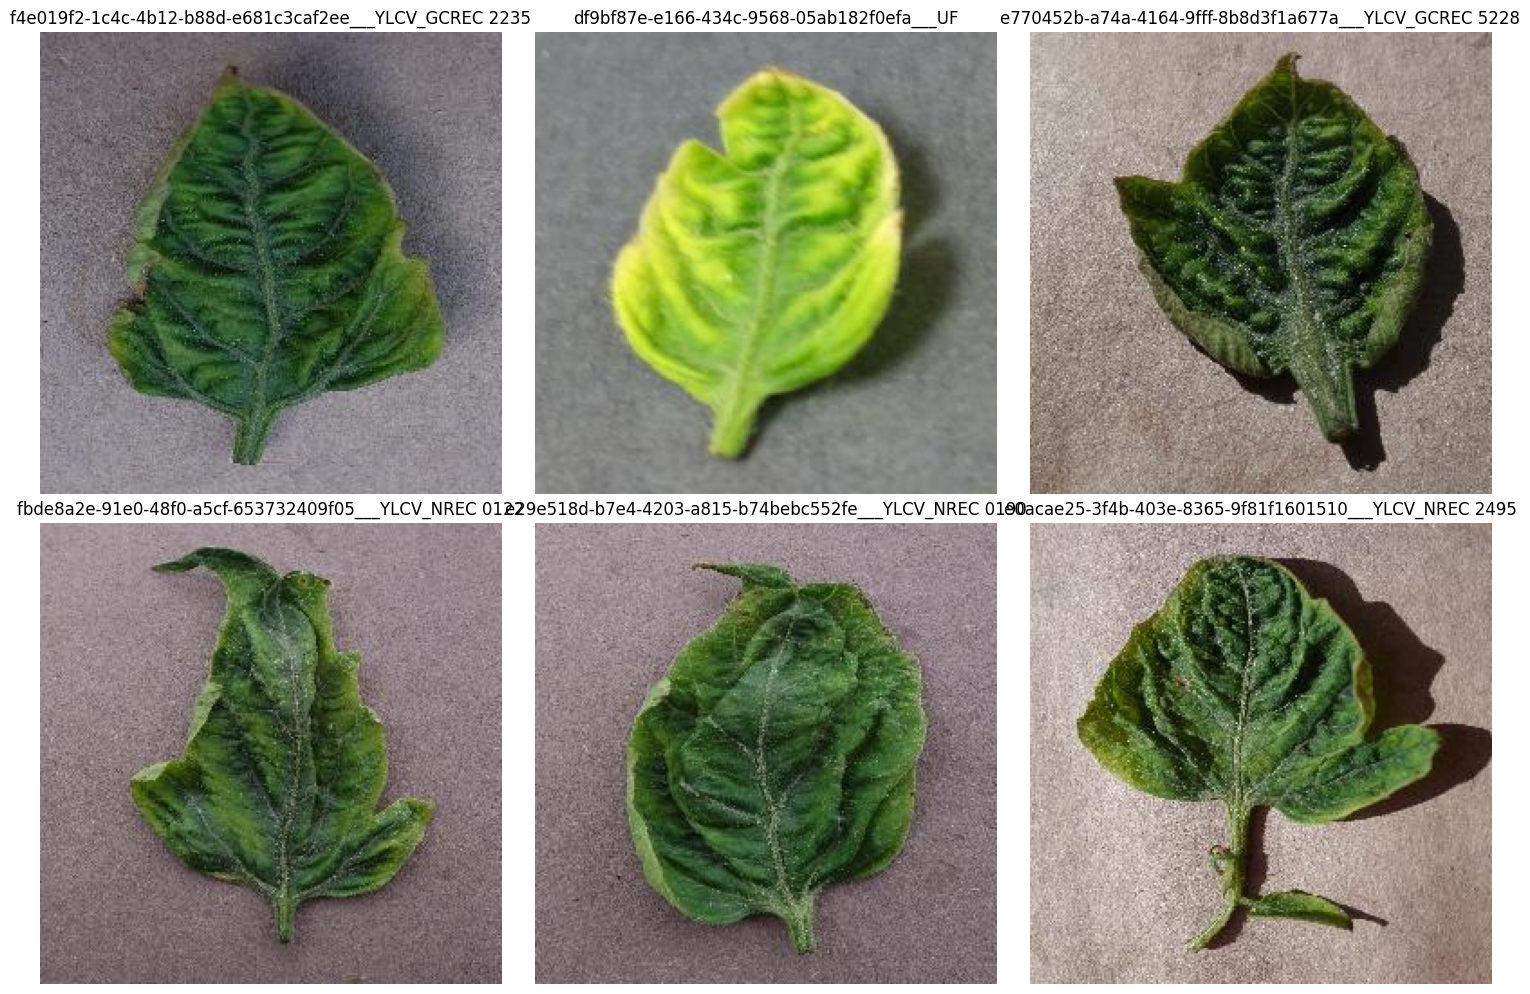

In [ ]:
path = "/content/tomato/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus"

image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    image_file = image_files[i]
    label = image_file.split('.')[0]

    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

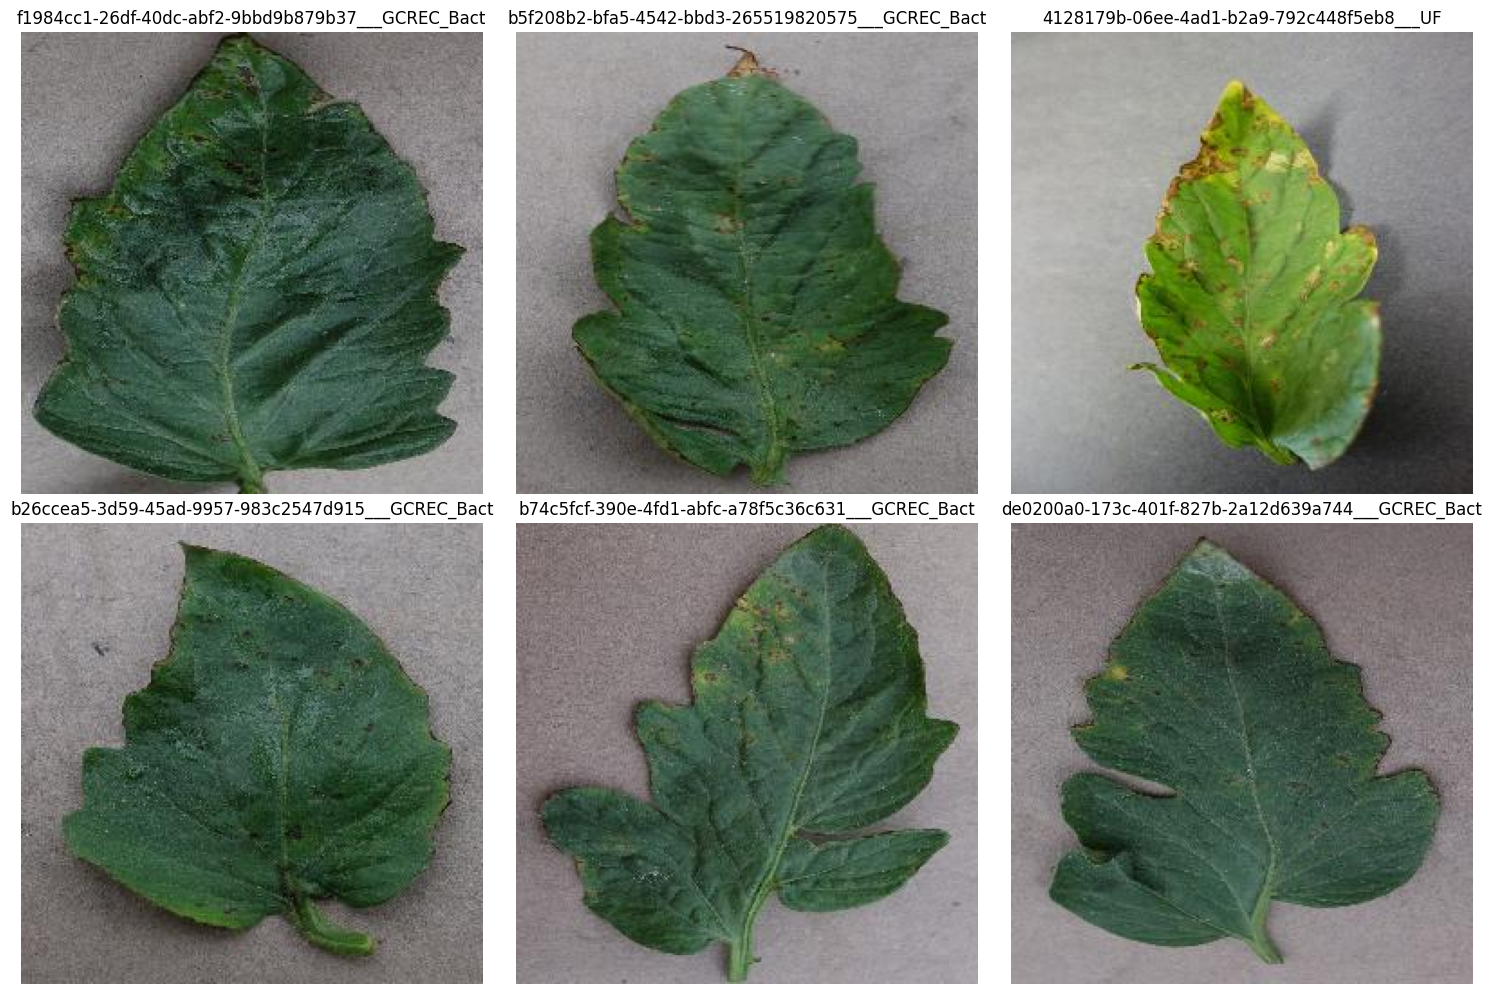

In [ ]:
# Path to the directory containing images
path = "/content/tomato/train/Tomato___Bacterial_spot"

# Get a list of all image file names in the directory
image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Display the first 6 images with their labels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    # Get the image file name and its label
    image_file = image_files[i]
    label = image_file.split('.')[0]

    # Load and display the image
    img_path = os.path.join(path, image_file)
    img = mpimg.imread(img_path)
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

plt.tight_layout()
plt.show()

### 8. Building the Deep Learning Model using Transfer Learning

We'll use `DenseNet121` as a pre-trained model, adding custom layers for tomato disease classification.

In [ ]:
conv_base = DenseNet121(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3),
    pooling='avg'
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.trainable = True

for layer in conv_base.layers[:121]:
    layer.trainable = False


In [ ]:
model = Sequential()
model.add(conv_base)
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(120, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

## **Model Training and Evaluation**

### 9. Training the Model

We will train the model on the preprocessed training data with early stopping to avoid overfitting.

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') is not None and logs.get('val_accuracy') >= 0.95:
            print("\nReached 95% validation accuracy, so cancelling training!")
            self.model.stop_training = True

callbacks = MyCallback()

In [ ]:

history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[callbacks]
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.6434 - loss: 1.1108
Reached 95% validation accuracy, so cancelling training!
313/313 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.6439 - loss: 1.1092 - val_accuracy: 0.9510 - val_loss: 0.1857


### 10. Evaluating the Model Performance

we will evaluate the model on the validation dataset and print the accuracy and loss.

In [ ]:
evaluation = model.evaluate(val_data)

print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 595ms/step - accuracy: 0.9471 - loss: 0.2066
Validation Loss: 0.19684192538261414
Validation Accuracy: 0.9470000267028809


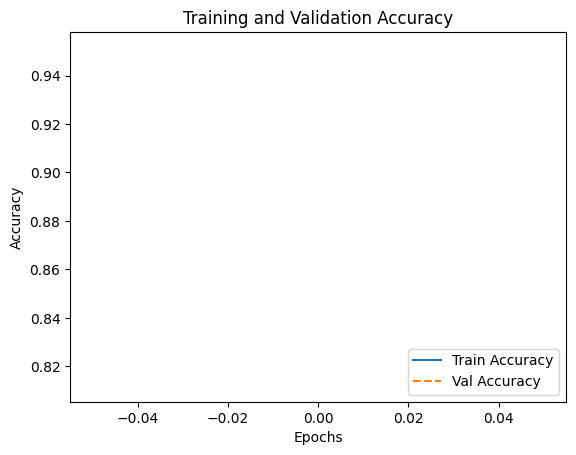

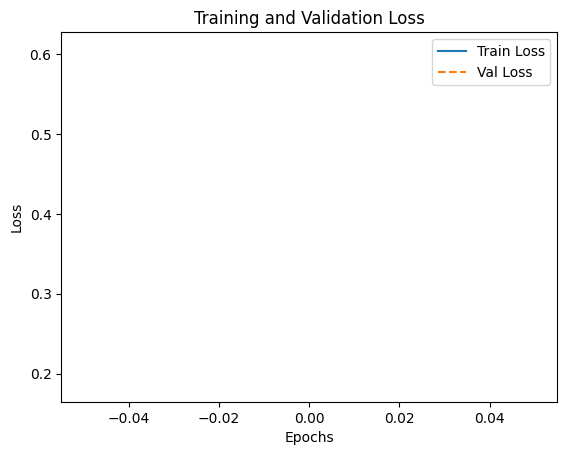

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
import numpy as np

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""

    image = tf.keras.utils.load_img(file, target_size=(256, 256))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)

    class_names = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold',
                   'Septoria_leaf_spot', 'Spider_mites', 'Target_Spot',
                   'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy']

    predicted_class = np.argmax(prediction)

    with out:
        print(f"{filename} termasuk dalam kelas '{class_names[predicted_class]}' dengan probabilitas {prediction[0][predicted_class]:.2f}")

    for i, class_name in enumerate(class_names):
        print(f"Probabilitas untuk {class_name}: {prediction[0][i]:.4f}")



In [ ]:
from ipywidgets import widgets
from io import BytesIO
import numpy as np
rescale_layer = tf.keras.layers.Rescaling(1./255)

uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""

    image = tf.keras.utils.load_img(file, target_size=(256, 256))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)


    prediction = model.predict(image, verbose=0)


    class_names = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold',
                   'Septoria_leaf_spot', 'Spider_mites', 'Target_Spot',
                   'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy']


    predicted_class = np.argmax(prediction)

    with out:
        print(f"{filename} termasuk dalam kelas '{class_names[predicted_class]}' dengan probabilitas {prediction[0][predicted_class]:.2f}")

    for i, class_name in enumerate(class_names):
        print(f"Probabilitas untuk {class_name}: {prediction[0][i]:.4f}")


def on_upload_change(change):
    """ A function for getting files from the widget and running the prediction."""
    items = change.new
    for filename, file_data in items.items():
        file_jpgdata = BytesIO(file_data['content'])
        file_predict(filename, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()